# Setup

In [1]:
import glob
import numpy as np
from copy import deepcopy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from random import randint
import cv2

In [2]:
def file_lines_to_list(path):
    # open txt file lines to a list
    with open(path) as f:
        content = f.readlines()
    # remove whitespace characters like `\n` at the end of each line
    content = [(x.strip()).split() for x in content]
    return content

def get_file_name(path):
    basename = os.path.basename(path)
    onlyname = os.path.splitext(basename)[0]
    return onlyname

In [25]:
def rgb_display(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Calculate GT/TP and Draw Graphs

In [3]:
def calc_iou(gt_bbox, pred_bbox):
    '''
    This function takes the predicted bounding box and ground truth bounding box and 
    return the IoU ratio
    '''
    x_topleft_gt, y_topleft_gt, x_bottomright_gt, y_bottomright_gt = gt_bbox
    x_topleft_p, y_topleft_p, x_bottomright_p, y_bottomright_p = pred_bbox
    
    if (x_topleft_gt > x_bottomright_gt) or (y_topleft_gt > y_bottomright_gt):
        raise AssertionError("Ground Truth Bounding Box is not correct")
    if (x_topleft_p > x_bottomright_p) or (y_topleft_p > y_bottomright_p):
        raise AssertionError("Predicted Bounding Box is not correct")
        
    #if the GT bbox and predcited BBox do not overlap then iou=0
    if(x_bottomright_gt < x_topleft_p):      
        return 0.0
    if(y_bottomright_gt < y_topleft_p):        
        return 0.0
    if(x_topleft_gt > x_bottomright_p):      
        return 0.0
    if(y_topleft_gt > y_bottomright_p):
        return 0.0
    
    GT_bbox_area = (x_bottomright_gt - x_topleft_gt + 1) * (y_bottomright_gt - y_topleft_gt + 1)
    Pred_bbox_area = (x_bottomright_p - x_topleft_p + 1 ) * (y_bottomright_p - y_topleft_p + 1)
    
    x_top_left = np.max([x_topleft_gt, x_topleft_p])
    y_top_left = np.max([y_topleft_gt, y_topleft_p])
    x_bottom_right = np.min([x_bottomright_gt, x_bottomright_p])
    y_bottom_right = np.min([y_bottomright_gt, y_bottomright_p])
    
    intersection_area = (x_bottom_right - x_top_left + 1) * (y_bottom_right - y_top_left  + 1)
    
    union_area = (GT_bbox_area + Pred_bbox_area - intersection_area)
   
    return intersection_area/union_area

In [4]:
def process_single_image_results(gt_boxes, pred_boxes, iou_thr):

    detected_obj_boxes = []

    if len(pred_boxes) > 0 and len(gt_boxes) > 0:
    
        gt_idx_thr=[]
        pred_idx_thr=[]
        ious=[]

        for igb, gt_box in enumerate(gt_boxes):
            for ipb, pred_box in enumerate(pred_boxes):
                iou = calc_iou(gt_box, pred_box)

                if iou >= iou_thr:
                    detected_obj_boxes.append(gt_box)
#                 break
    
    return detected_obj_boxes

# Print Detection Results + IoUs + Boxes

In [6]:
gt_path = glob.glob("./608_sub_samples/patch-labels-train/*.txt")

print(len(gt_path))
print(gt_path[0])

44643
./608_sub_samples/patch-labels-train\0000f77c-62c2a288_608_0.txt


In [114]:
index = randint(0, len(gt_path)-1)

path = gt_path[index]
img_name = get_file_name(path)
print(img_name)

result_file_name = "subsampling608_pedestrian_resyolo_trainset_det_epoch49"

gt_boxes_list = file_lines_to_list(f"./608_sub_samples/patch-labels-train/{img_name}.txt")
det_boxes_list = file_lines_to_list(f"./608_sub_samples/hard-negative-mining/{result_file_name}/{img_name}.txt")

print(gt_boxes_list)
print(det_boxes_list)

77b9d7ff-25608d61_608_1
[['person', '518', '262', '546', '334'], ['person', '553', '264', '595', '336']]
[['person', '0.935893', '519', '264', '545', '329'], ['person', '0.877263', '555', '269', '586', '335'], ['person', '0.461517', '385', '273', '396', '294'], ['person', '0.291567', '204', '269', '218', '292'], ['person', '0.264393', '128', '271', '140', '290'], ['person', '0.247789', '69', '268', '83', '297'], ['person', '0.244852', '35', '262', '47', '289'], ['person', '0.207465', '96', '262', '130', '294']]


GT Boxes: [['person', '518', '262', '546', '334'], ['person', '553', '264', '595', '336']]
DET Boxes: [['person', '0.935893', '519', '264', '545', '329'], ['person', '0.877263', '555', '269', '586', '335'], ['person', '0.461517', '385', '273', '396', '294'], ['person', '0.291567', '204', '269', '218', '292'], ['person', '0.264393', '128', '271', '140', '290'], ['person', '0.247789', '69', '268', '83', '297'], ['person', '0.244852', '35', '262', '47', '289'], ['person', '0.207465', '96', '262', '130', '294']]
IoU [0.8417572035899858, 0.6830200700860146]
Score ['0.935893', '0.877263']
Index [0, 1]


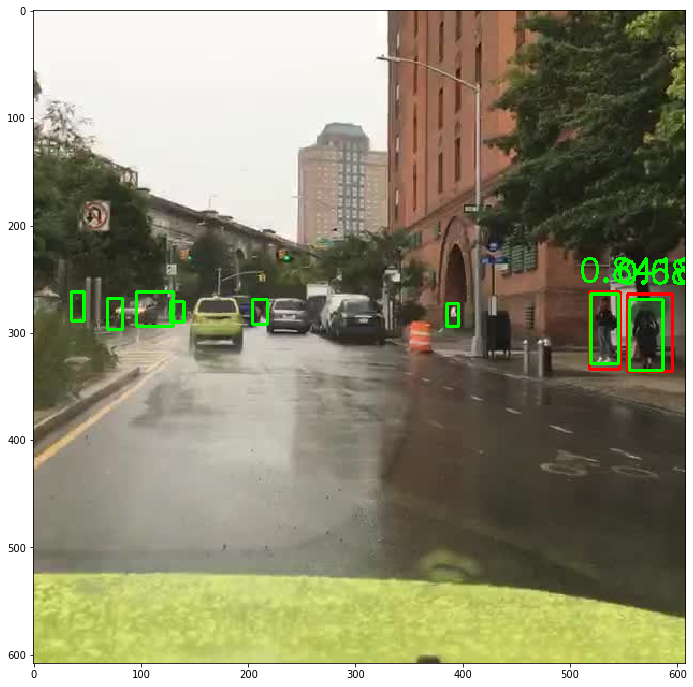

In [115]:
# gt_boxes_list = file_lines_to_list(f"./608_sub_samples/patch-labels-train/{img_name}.txt")
# det_boxes_list = file_lines_to_list(f"./608_sub_samples/hard-negative-mining/{result_file_name}/{img_name}.txt")

iou_list = []
score_list = []
index_list = []

if len(det_boxes_list) > 0:
    for gt_box in gt_boxes_list:
        iou_list_i = []
        for det_box in det_boxes_list:
            array_gt = [int(gt_box[1]), int(gt_box[2]), int(gt_box[3]), int(gt_box[4])]
            array_det = [int(det_box[2]), int(det_box[3]), int(det_box[4]), int(det_box[5])]

            iou = calc_iou(array_gt, array_det)

            iou_list_i.append(iou)

        max_iou_i = np.amax(iou_list_i)
        index_max = np.argmax(iou_list_i)

        iou_list.append(max_iou_i)
        score_list.append(det_boxes_list[index_max][1])
        index_list.append(index_max)

else:
    for gt_box in gt_boxes_list:
        iou_list.append(0)
        
print("GT Boxes:", gt_boxes_list)    
print("DET Boxes:", det_boxes_list)
print("IoU", iou_list)
print("Score", score_list)
print("Index", index_list)

img = cv2.imread(f"./608_sub_samples/patches-train/{img_name}.jpg")

dummy = img.copy()

for i in range(len(gt_boxes_list)):
    obj = gt_boxes_list[i]
    cv2.rectangle(dummy, (int(obj[1]), int(obj[2])), (int(obj[3]), int(obj[4])), (0, 0, 255), thickness = 2)
    cv2.putText(dummy, str("{:.4f}".format(iou_list[i])), (int(obj[1])-10, int(obj[2])-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

for obj in det_boxes_list:
    cv2.rectangle(dummy, (int(obj[2]), int(obj[3])), (int(obj[4]), int(obj[5])), (0, 255, 0), thickness = 2)

plt.figure(figsize = (12, 12))
plt.imshow(rgb_display(dummy))
plt.show()

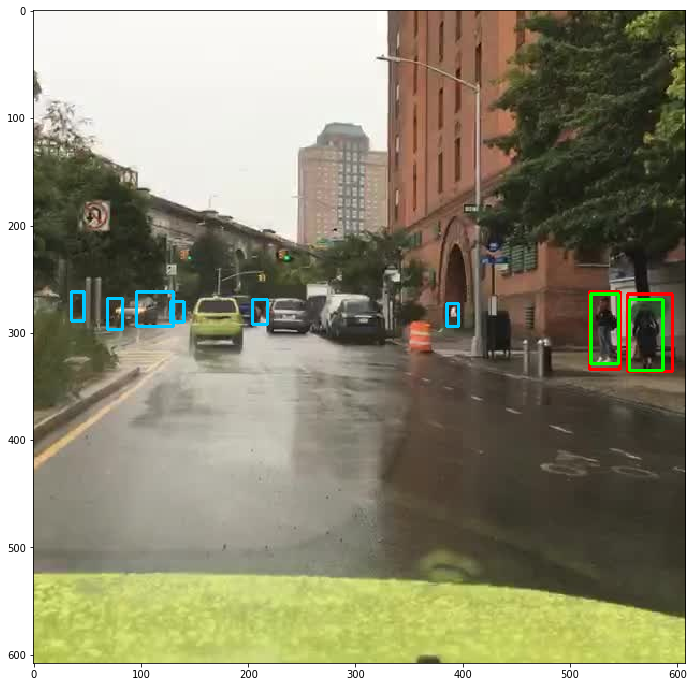

In [116]:
tp_list = []
fp_list = []

for i in range(len(det_boxes_list)):
    if i in index_list: tp_list.append(det_boxes_list[i])
    else: fp_list.append(det_boxes_list[i])
        
dummy = img.copy()

for i in range(len(gt_boxes_list)):
    obj = gt_boxes_list[i]
    cv2.rectangle(dummy, (int(obj[1]), int(obj[2])), (int(obj[3]), int(obj[4])), (0, 0, 255), thickness = 2)
    # cv2.putText(dummy, str("{:.4f}".format(iou_list[i])), (int(obj[1])-10, int(obj[2])-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

for obj in tp_list:
    cv2.rectangle(dummy, (int(obj[2]), int(obj[3])), (int(obj[4]), int(obj[5])), (0, 255, 0), thickness = 2)
    
for obj in fp_list:
    cv2.rectangle(dummy, (int(obj[2]), int(obj[3])), (int(obj[4]), int(obj[5])), (255, 200, 0), thickness = 2)

plt.figure(figsize = (12, 12))
plt.imshow(rgb_display(dummy))
plt.show()

In [74]:
# GEN HARD NEGATIVE MINING DATA #
gt_path = glob.glob("./608_sub_samples/patch-labels-train/*.txt")
text_file = open(f"./608_sub_samples/hard-negative-mining/bdd100k_608_subsamples_hnm_train.txt", "w+")

count=0
for path in gt_path:
    img_name = get_file_name(path)

    gt_boxes_list = file_lines_to_list(f"./608_sub_samples/patch-labels-train/{img_name}.txt")
    det_boxes_list = file_lines_to_list(f"./608_sub_samples/hard-negative-mining/{result_file_name}/{img_name}.txt")

    index_list = []

    if len(det_boxes_list) > 0:
        for gt_box in gt_boxes_list:
            iou_list_i = []
            for det_box in det_boxes_list:
                array_gt = [int(gt_box[1]), int(gt_box[2]), int(gt_box[3]), int(gt_box[4])]
                array_det = [int(det_box[2]), int(det_box[3]), int(det_box[4]), int(det_box[5])]

                iou = calc_iou(array_gt, array_det)

                iou_list_i.append(iou)

            max_iou_i = np.amax(iou_list_i)
            index_max = np.argmax(iou_list_i)
            index_list.append(index_max)

            fp_list = []

            for i in range(len(det_boxes_list)):
                if i not in index_list and len(fp_list) < 2*len(gt_boxes_list)+1:
                    fp_list.append(det_boxes_list[i])

        text_file.write(f'/home/mju-hpc-02/Leanh/datasets/bdd100k-modification/608-subsamples/patches-train/{img_name}.jpg ')
    
        for box in gt_boxes_list:
            text_file.write('{},{},{},{},{} '.format(box[1], box[2], box[3], box[4], 0))

        for box in fp_list:
            text_file.write('{},{},{},{},{} '.format(box[2], box[3], box[4], box[5], 1))
        text_file.write('\n')
        
    count+=1 
    print(count, len(gt_path))

1 44643
2 44643
3 44643
4 44643
5 44643
6 44643
7 44643
8 44643
9 44643
10 44643
11 44643
12 44643
13 44643
14 44643
15 44643
16 44643
17 44643
18 44643
19 44643
20 44643
21 44643
22 44643
23 44643
24 44643
25 44643
26 44643
27 44643
28 44643
29 44643
30 44643
31 44643
32 44643
33 44643
34 44643
35 44643
36 44643
37 44643
38 44643
39 44643
40 44643
41 44643
42 44643
43 44643
44 44643
45 44643
46 44643
47 44643
48 44643
49 44643
50 44643
51 44643
52 44643
53 44643
54 44643
55 44643
56 44643
57 44643
58 44643
59 44643
60 44643
61 44643
62 44643
63 44643
64 44643
65 44643
66 44643
67 44643
68 44643
69 44643
70 44643
71 44643
72 44643
73 44643
74 44643
75 44643
76 44643
77 44643
78 44643
79 44643
80 44643
81 44643
82 44643
83 44643
84 44643
85 44643
86 44643
87 44643
88 44643
89 44643
90 44643
91 44643
92 44643
93 44643
94 44643
95 44643
96 44643
97 44643
98 44643
99 44643
100 44643
101 44643
102 44643
103 44643
104 44643
105 44643
106 44643
107 44643
108 44643
109 44643
110 44643
111 4464

844 44643
845 44643
846 44643
847 44643
848 44643
849 44643
850 44643
851 44643
852 44643
853 44643
854 44643
855 44643
856 44643
857 44643
858 44643
859 44643
860 44643
861 44643
862 44643
863 44643
864 44643
865 44643
866 44643
867 44643
868 44643
869 44643
870 44643
871 44643
872 44643
873 44643
874 44643
875 44643
876 44643
877 44643
878 44643
879 44643
880 44643
881 44643
882 44643
883 44643
884 44643
885 44643
886 44643
887 44643
888 44643
889 44643
890 44643
891 44643
892 44643
893 44643
894 44643
895 44643
896 44643
897 44643
898 44643
899 44643
900 44643
901 44643
902 44643
903 44643
904 44643
905 44643
906 44643
907 44643
908 44643
909 44643
910 44643
911 44643
912 44643
913 44643
914 44643
915 44643
916 44643
917 44643
918 44643
919 44643
920 44643
921 44643
922 44643
923 44643
924 44643
925 44643
926 44643
927 44643
928 44643
929 44643
930 44643
931 44643
932 44643
933 44643
934 44643
935 44643
936 44643
937 44643
938 44643
939 44643
940 44643
941 44643
942 44643
943 44643


1614 44643
1615 44643
1616 44643
1617 44643
1618 44643
1619 44643
1620 44643
1621 44643
1622 44643
1623 44643
1624 44643
1625 44643
1626 44643
1627 44643
1628 44643
1629 44643
1630 44643
1631 44643
1632 44643
1633 44643
1634 44643
1635 44643
1636 44643
1637 44643
1638 44643
1639 44643
1640 44643
1641 44643
1642 44643
1643 44643
1644 44643
1645 44643
1646 44643
1647 44643
1648 44643
1649 44643
1650 44643
1651 44643
1652 44643
1653 44643
1654 44643
1655 44643
1656 44643
1657 44643
1658 44643
1659 44643
1660 44643
1661 44643
1662 44643
1663 44643
1664 44643
1665 44643
1666 44643
1667 44643
1668 44643
1669 44643
1670 44643
1671 44643
1672 44643
1673 44643
1674 44643
1675 44643
1676 44643
1677 44643
1678 44643
1679 44643
1680 44643
1681 44643
1682 44643
1683 44643
1684 44643
1685 44643
1686 44643
1687 44643
1688 44643
1689 44643
1690 44643
1691 44643
1692 44643
1693 44643
1694 44643
1695 44643
1696 44643
1697 44643
1698 44643
1699 44643
1700 44643
1701 44643
1702 44643
1703 44643
1704 44643

KeyboardInterrupt: 